# Beta-Poisson (SymSim) datasets

## Imports

In [1]:
import glob
import pandas as pd
import numpy as np
import os
from IPython.display import HTML
import scipy
import torch
import pickle
import re
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from inspect import signature

In [2]:
from scvi.models import AutoZIVAE
from scvi.inference import UnsupervisedTrainer
from datasets.symsim import SymSimMixedDataset
import torch
import pickle
import argparse
import re
import numpy as np
import time
from scvi.models.log_likelihood import compute_marginal_log_likelihood_scvi, compute_marginal_log_likelihood_autozi
import os
from autozi_simulate_tools import retrieve_rates_dropouts
from classification_metrics import *
from functools import partial

[2019-10-11 19:27:09,786] INFO - scvi._settings | Added StreamHandler with custom formatter to 'scvi' logger.
/home/oscar/miniconda3/lib/python3.7/site-packages/scikit_learn-0.19.2-py3.7-linux-x86_64.egg/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
from mle_nb import NBEstimatorMinimize
from mle_zinb import ZINBEstimatorMinimize

In [4]:
plt.switch_backend("TkAgg")
%matplotlib inline

## Train AutoZI on datasets

For each dataset under scrutiny, we retrieve the posterior parameters $\alpha^g, \beta^g$ of $q(\delta_g)$ for each gene $g$.

In [5]:
results_autozi_outputs = []
datasets_mapper = {
    'symsimb000': partial(SymSimMixedDataset, ratios=(0, 100, 0)),
    'symsimb025': partial(SymSimMixedDataset, ratios=(25, 75, 0)),
    'symsimb050': partial(SymSimMixedDataset, ratios=(50, 50, 0)),
    'symsimb075': partial(SymSimMixedDataset, ratios=(75, 25, 0)),
    'symsimb100': partial(SymSimMixedDataset, ratios=(100, 0, 0)),
}

for dataset_name in datasets_mapper:
    data = datasets_mapper[dataset_name]()

    np.random.seed(int(time.time()))
    torch.manual_seed(int(time.time()))
    model = AutoZIVAE(n_input=data.nb_genes, alpha_prior=0.5, beta_prior=0.5,minimal_dropout=0.01)
    trainer = UnsupervisedTrainer(model, data)
    trainer.train(n_epochs=200, lr=1e-2)
    outputs = trainer.model.get_alphas_betas(as_numpy=True)
    outputs['dataset_name'] = dataset_name
    outputs['gene_labels'] = data.gene_labels
    results_autozi_outputs.append(outputs)

[2019-10-11 19:27:12,888] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2019-10-11 19:27:12,889] INFO - scvi.dataset.dataset | Remapping labels to [0,N]


training: 100%|██████████| 200/200 [00:38<00:00,  5.07it/s]


[2019-10-11 19:27:52,959] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2019-10-11 19:27:52,960] INFO - scvi.dataset.dataset | Remapping labels to [0,N]


training: 100%|██████████| 200/200 [00:39<00:00,  5.40it/s]


[2019-10-11 19:28:31,993] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2019-10-11 19:28:31,994] INFO - scvi.dataset.dataset | Remapping labels to [0,N]


training: 100%|██████████| 200/200 [00:38<00:00,  5.09it/s]


[2019-10-11 19:29:10,462] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2019-10-11 19:29:10,463] INFO - scvi.dataset.dataset | Remapping labels to [0,N]


training: 100%|██████████| 200/200 [00:40<00:00,  4.73it/s]

[2019-10-11 19:29:51,439] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2019-10-11 19:29:51,440] INFO - scvi.dataset.dataset | Remapping labels to [0,N]



training: 100%|██████████| 200/200 [00:46<00:00,  4.34it/s]


## Compute metrics from AutoZI's outputs

For each dataset under scrutiny, from these $\alpha^g, \beta^g$, we estimate the ZI probabilities $q(\delta_g < 0.5)$ and confusion matrix metrics on the default decision rule $q(\delta_g < 0.5) > 0.5$ using tools from `classification_metrics.py`.

In [9]:
results_autozi_data_list = []

for outputs in results_autozi_outputs:
    
    gene_labels = outputs['gene_labels']
    # Focus on bimodal and UNZ genes (by default no UZ gene should be in the dataset)
    mask_selection = np.argwhere(gene_labels != 'uz').reshape(-1)
    if mask_selection.sum() == 0:
        continue
    is_zinb_gt = (outputs['gene_labels'] == 'b')[mask_selection]
    
    dataset_name = outputs['dataset_name']

    metric_list_bernoulli = [
        ConfusionMatrixMetric(is_zinb_gt),
    ]

    model_score_evals = [
        AutoZIBernoulliThresholdEval('bernoullithreshold50', outputs, metric_list_bernoulli, threshold=0.50,
                                     mask_selection=mask_selection),
    ]

    results_autozi_data = {}
    for model_score_eval in model_score_evals:
        # Compute metrics for AutoZI on the dataset (here confusion matrix metrics)
        # Positives are ZI genes 
        results_autozi_data.update(model_score_eval.compute_all_metrics())
        # Also directly add the scores used to compute the metrics
        results_autozi_data[model_score_eval.name] = model_score_eval.scores
    results_autozi_data['is_zinb_gt'] = is_zinb_gt

    results_autozi_data['dataset_name'] = outputs.get('dataset_name',None)
        
    results_autozi_data_list.append(results_autozi_data)

results_autozi = pd.DataFrame(results_autozi_data_list)

In [10]:
results_autozi = results_autozi.sort_values(by=['dataset_name']).set_index(['dataset_name'])

## Run baselines on datasets

For each dataset under scrutiny, for each gene $g$, we return the results of AIC, BIC, the LLs of the fitted NB and ZINB distributions and the estimate ZI rate from the ZINB distribution.

In [22]:
results_baseline_outputs = []

datasets_mapper = {
    'symsimb000': partial(SymSimMixedDataset, ratios=(0, 100, 0)),
    'symsimb025': partial(SymSimMixedDataset, ratios=(25, 75, 0)),
    'symsimb050': partial(SymSimMixedDataset, ratios=(50, 50, 0)),
    'symsimb075': partial(SymSimMixedDataset, ratios=(75, 25, 0)),
    'symsimb100': partial(SymSimMixedDataset, ratios=(100, 0, 0)),
}

for dataset_name in datasets_mapper:
    data = datasets_mapper[dataset_name]()

    outputs = {}


    nb_is_best_bic_list = []
    nb_is_best_aic_list = []
    lls_nb = []
    lls_zinb = []
    dropouts = []

    for g in range(data.X.shape[1]):
        X = data.X[:, g]

        zinb_est_min = ZINBEstimatorMinimize()
        nb_est_min = NBEstimatorMinimize()


        zinb_est_min.fit(X, method='trust-constr', options={'maxiter': 1000})
        nb_est_min.fit(X, method='trust-constr', options={'maxiter': 1000})

        ll_nb = nb_est_min.compute_ll(X)
        ll_zinb = zinb_est_min.compute_ll(X)

        # BIC
        bic_nb = -2 * ll_nb + 2 * np.log(X.size)
        bic_zinb = -2 * ll_zinb + 3 * np.log(X.size)
        nb_is_best_g_bic = bic_nb < bic_zinb

        # AIC
        aic_nb = -2 * ll_nb + 2 * 2
        aic_zinb = -2 * ll_zinb + 3 * 2
        nb_is_best_g_aic = aic_nb < aic_zinb

        # ZI rates and LLs
        dropouts.append(zinb_est_min.pi)
        lls_nb.append(ll_nb)
        lls_zinb.append(ll_zinb)
        nb_is_best_bic_list.append(nb_is_best_g_bic)
        nb_is_best_aic_list.append(nb_is_best_g_aic)





    outputs['gene_labels'] = data.gene_labels
    outputs['is_nb_pred_bic'] = np.array(nb_is_best_bic_list)
    outputs['is_nb_pred_aic'] = np.array(nb_is_best_aic_list)
    outputs['dropouts'] = np.array(dropouts)
    outputs['lls_nb'] = lls_nb
    outputs['lls_zinb'] = lls_zinb
    outputs['dataset_name'] = dataset_name
    
    results_baseline_outputs.append(outputs)

[2019-10-11 21:07:21,415] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2019-10-11 21:07:21,416] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2019-10-11 21:08:06,063] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2019-10-11 21:08:06,063] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2019-10-11 21:08:47,526] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2019-10-11 21:08:47,527] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2019-10-11 21:09:38,926] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2019-10-11 21:09:38,926] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2019-10-11 21:10:28,712] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2019-10-11 21:10:28,713] INFO - scvi.dataset.dataset | Remapping labels to [0,N]


## Compute metrics from the baseline's outputs

From the outputs above, we compute confusion matrix metrics for AIC/BIC and return values of ZI rates and differences of log-likelihoods using tools from `classification_metrics.py`.

In [23]:
results_baseline_data_list = []

for outputs in results_baseline_outputs:
    gene_labels = outputs['gene_labels']
    mask_selection = np.argwhere(gene_labels != 'uz').reshape(-1)
    if mask_selection.sum() == 0:
        continue
    is_zinb_gt = (outputs['gene_labels'] == 'b')[mask_selection]
    
    metric_list_fitdecision = [
        ConfusionMatrixMetric(is_zinb_gt),
    ]

    model_score_evals = [
        FitDecisionEval('baselinedecisionaic', outputs, metric_list_fitdecision, key='aic',
                        mask_selection=mask_selection),
        FitDecisionEval('baselinedecisionbic', outputs, metric_list_fitdecision, key='bic',
                        mask_selection=mask_selection),
        FitDropoutEval('baselinedropout', outputs, [], key=None,
                       mask_selection=mask_selection),
        FitDiffLLEval('baselinediffll', outputs, [],
                      mask_selection=mask_selection),
    ]

    results_baseline_data = {}
    for model_score_eval in model_score_evals:
        # Compute metrics for the baselines on the dataset (here confusion matrix metrics)
        # They are computed only for the AIC and BIC baselines
        # Positives are ZI genes
        results_baseline_data.update(model_score_eval.compute_all_metrics())
        # Also directly add the scores used to compute the metrics
        # Relevant only for ZI rates and differences of LLs
        results_baseline_data[model_score_eval.name] = model_score_eval.scores
    results_baseline_data['is_zinb_gt'] = is_zinb_gt
    results_baseline_data['dataset_name'] = outputs.get('dataset_name',None)
    results_baseline_data_list.append(results_baseline_data)

results_baseline = pd.DataFrame(results_baseline_data_list)

In [24]:
results_baseline = results_baseline.sort_values(by=['dataset_name']).set_index(['dataset_name'])

## Results on decisions rules

AutoZI default : $q(\delta_g < 0.5) > 0.5$

In [25]:
results_autozi_restricted_sum = results_autozi[['bernoullithreshold50_confusionmatrix_tp',\
                                                'bernoullithreshold50_confusionmatrix_fp',\
                                                'bernoullithreshold50_confusionmatrix_tn',\
                                                'bernoullithreshold50_confusionmatrix_fn']].sum()

tpr_aggregated = results_autozi_restricted_sum['bernoullithreshold50_confusionmatrix_tp']\
                / (results_autozi_restricted_sum['bernoullithreshold50_confusionmatrix_tp']\
                  + results_autozi_restricted_sum['bernoullithreshold50_confusionmatrix_fn'])
fpr_aggregated = results_autozi_restricted_sum['bernoullithreshold50_confusionmatrix_fp']\
                / (results_autozi_restricted_sum['bernoullithreshold50_confusionmatrix_fp']\
                  + results_autozi_restricted_sum['bernoullithreshold50_confusionmatrix_tn'])
print('TPR :', tpr_aggregated)
print('FPR :', fpr_aggregated)

TPR : 0.96
FPR : 0.008


AIC

In [26]:
results_baseline_restricted_sum = results_baseline[['baselinedecisionaic_confusionmatrix_tp',\
                                          'baselinedecisionaic_confusionmatrix_fp',\
                                          'baselinedecisionaic_confusionmatrix_tn',\
                                          'baselinedecisionaic_confusionmatrix_fn']].sum()

tpr_aggregated = results_baseline_restricted_sum['baselinedecisionaic_confusionmatrix_tp']\
                / (results_baseline_restricted_sum['baselinedecisionaic_confusionmatrix_tp']\
                  + results_baseline_restricted_sum['baselinedecisionaic_confusionmatrix_fn'])
fpr_aggregated = results_baseline_restricted_sum['baselinedecisionaic_confusionmatrix_fp']\
                / (results_baseline_restricted_sum['baselinedecisionaic_confusionmatrix_fp']\
                  + results_baseline_restricted_sum['baselinedecisionaic_confusionmatrix_tn'])
print('TPR :', tpr_aggregated)
print('FPR :', fpr_aggregated)

TPR : 0.992
FPR : 0.948


BIC

In [27]:
results_baseline_restricted_sum = results_baseline[['baselinedecisionbic_confusionmatrix_tp',\
                                          'baselinedecisionbic_confusionmatrix_fp',\
                                          'baselinedecisionbic_confusionmatrix_tn',\
                                          'baselinedecisionbic_confusionmatrix_fn']].sum()

tpr_aggregated = results_baseline_restricted_sum['baselinedecisionbic_confusionmatrix_tp']\
                / (results_baseline_restricted_sum['baselinedecisionbic_confusionmatrix_tp']\
                  + results_baseline_restricted_sum['baselinedecisionbic_confusionmatrix_fn'])
fpr_aggregated = results_baseline_restricted_sum['baselinedecisionbic_confusionmatrix_fp']\
                / (results_baseline_restricted_sum['baselinedecisionbic_confusionmatrix_fp']\
                  + results_baseline_restricted_sum['baselinedecisionbic_confusionmatrix_tn'])
print('TPR :', tpr_aggregated)
print('FPR :', fpr_aggregated)

TPR : 0.94
FPR : 0.768


## ROC curves

### Create each curve

AutoZI : $q(\delta_g < 0.5)$

In [28]:
scores_autozi_all = np.concatenate(list(results_autozi.bernoullithreshold50.values.reshape(-1))).reshape(-1)
is_zinb_gt_all = np.concatenate(list(results_autozi.is_zinb_gt.values.reshape(-1))).reshape(-1)
fpr_autozi, tpr_autozi, _ = roc_curve(is_zinb_gt_all, scores_autozi_all)
auc_val_autozi = auc(fpr_autozi,tpr_autozi)

Uni-MLE-LRT

In [29]:
scores_baselinediffll_all = np.concatenate(list(results_baseline[['baselinediffll']].values.reshape(-1))).reshape(-1)
is_zinb_gt_all = np.concatenate(list(results_baseline[['is_zinb_gt']].values.reshape(-1))).reshape(-1)
fpr_baselinediffll, tpr_baselinediffll, _ = roc_curve(is_zinb_gt_all, scores_baselinediffll_all)
auc_val_baselinediffll = auc(fpr_baselinediffll,tpr_baselinediffll)

Uni-MLE-Pi

In [30]:
scores_baselinedropout_all = np.concatenate(list(results_baseline[['baselinedropout']].values.reshape(-1))).reshape(-1)
is_zinb_gt_all = np.concatenate(list(results_baseline[['is_zinb_gt']].values.reshape(-1))).reshape(-1)
fpr_baselinedropout, tpr_baselinedropout, _ = roc_curve(is_zinb_gt_all, scores_baselinedropout_all)
auc_val_baselinedropout = auc(fpr_baselinedropout,tpr_baselinedropout)

### Plot all ROC curves together

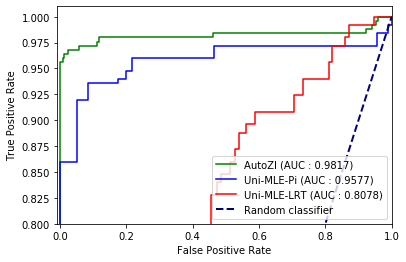

In [31]:
for fpr,tpr,model_name,color in zip([fpr_autozi,fpr_baselinedropout,fpr_baselinediffll],\
                                    [tpr_autozi,tpr_baselinedropout,tpr_baselinediffll],\
                                    ['AutoZI','Uni-MLE-Pi','Uni-MLE-LRT'],\
                                    ['g','b','r']):
    auc_val = auc(fpr,tpr)
    plt.plot(fpr, tpr, label='{model_name} (AUC : {auc})'.format(model_name=model_name,auc=round(auc_val,4)),color=color)

plt.plot([0, 1], [0, 1], label='Random classifier', color='navy', lw=2, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.8, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()